In [1]:
%run ./tools.ipynb
from util.functions import create_masks

In [2]:
def plot_xco2_diff(diff_before, diff_after, lat_slice, lon_slice, imonth):
    '''Produce plots of XCO2 differences
    inputs (1d arrays): 
        diff in XCO2, before and after
        lat_slice, lon_slice, lat and lon for each data point
        imonth, month number, for plot title
    outputs: plots
        '''
    nobs = len(diff_before)
    # Creat target dataarray and dataset
    lat_res = 2.    # horizontal resolution of lat and lon you would want
    lon_res = 2.5
    lat = np.linspace(-90, 90, int(180/lat_res + 1)) # grid
    lon = np.linspace(-180, 177.5, int(360/lon_res))
    diff_1 = xr.DataArray(data = np.nan, 
                        dims = ('lat', 'lon'), 
                        coords = {'lat': lat,
                                'lon': lon},
                        name = 'diff')
    diff_2 = xr.DataArray(data = np.nan, 
                        dims = ('lat', 'lon'), 
                        coords = {'lat': lat,
                                'lon': lon},
                        name = 'diff')
    # map 1d data onto dataarray
    for i in range(nobs):
        lat = int((lat_slice[i].values + 90)/2) # lat index
        lon = int((lon_slice[i].values + 180)/2.5)
        diff_1[lat, lon] = -diff_before[i]
        diff_2[lat, lon] = -diff_after[i]
    print('y diff before:',"{:.2f}".format(diff_1.mean().values))
    print('y diff after:',"{:.2f}".format(diff_2.mean().values))

    # figure 1, distribution
    fig, axes = plt.subplots(1, 2, 
                             figsize=[14, 6], 
                             subplot_kw={'projection': ccrs.PlateCarree()},
                             gridspec_kw={'hspace': 0.2, 'wspace': 0})
    # before
    diff_1.plot(ax=axes[0], vmax = 3, add_labels = False, cbar_kwargs={'shrink': 0.5})
    axes[0].set_title(short_name_of_month(imonth) + ' XCO2: a prior - OCO2', loc='left')
    axes[0].set_title('ppm', loc = 'right')
    axes[0].coastlines()
    axes[0].gridlines(linestyle = '--')
    # after
    diff_2.plot(ax=axes[1], vmax = 3, add_labels = False, cbar_kwargs={'shrink': 0.5})
    axes[1].set_title(short_name_of_month(imonth) + ' XCO2: a posterior - OCO2', loc='left')
    axes[1].set_title('ppm', loc = 'right')
    axes[1].coastlines()
    axes[1].gridlines(linestyle = '--')

    fig.savefig(mod_dir + 'bio_results_map_diff_' + str(imonth) + '.png', dpi=300)
    
    # figure 2, scatter plot
    fig = plt.figure(figsize=[5,5])
    plt.plot([300,450],[300,450], c='black')
    plt.scatter(xco2_oco_slice, xco2_mod_slice, s=0.7, label = 'A prior')
    plt.scatter(xco2_oco_slice, xco2_oco_slice - diff_after, s=0.7, label = 'A posterior')
    plt.ylim(top   = 420,bottom = 395)
    plt.xlim(right = 420,left   = 395)
    plt.title(name_month + ' XCO2 (ppm)')
    plt.ylabel('GEOS-Chem')
    plt.xlabel('OCO2')
    plt.legend(markerscale = 4)
    
    fig.savefig(mod_dir + 'bio_results_scatter_diff_' + str(imonth) + '.png', dpi=300)
    

In [3]:
# all fluxes used in simulations
fname = '/geos/u73/msadiq/GEOS-Chem/HEMCO/CO2/v2019-12/monthly_emission.nc'
ds_monthly = xr.open_dataset(fname)
dr_monthly = ds_monthly['ff'] # just for making a mask

# create masks for this resolution
dr = dr_monthly[0,:,:]
# create masks for input file
mask = create_masks(input_file=dr, 
                    input_file_type='dataarray', 
                    var_name='', 
                    mask_type='giorgi', 
                    output_format='xarray', 
                    output_path='/geos/u73/msadiq/GEOS-Chem/MASKS/nc/giorgi/', 
                    figure_flag = False, 
                    figure_path='/home/msadiq/Desktop/co2/data/emission/MASKS/figures/')

# split masks into separate dataarrays, with 1 for masked area, 0 for elsewhere
target = dr.copy()
target[:,:] = 0.
ds_masks = target.to_dataset(name = 'MASK1')

nm_masks = int(mask.max().values) # number of masks
for count in range(1,nm_masks+1): # + ocean
    target = dr.copy()
    target[:,:] = 0.
        
    mask_TF = mask == count # True or False map
    target = mask_TF.where(True)
    name_tmp = 'MASK' + str(count)
    ds_masks[name_tmp] = target

# monthly net fluxes for 22 tagged regions
monthly_net_flux_casa = np.zeros((12,nm_masks+1))
dr_monthly = ds_monthly['ff'] + ds_monthly['fire'] + ds_monthly['ocean'] + ds_monthly['nte'] + ds_monthly['casa_bio']

for i in range(12):
    for j in range(nm_masks):
        mask_name = 'MASK' + str(j+1)
        tmp = dr_monthly[i,:,:] * ds_masks[mask_name]
        monthly_net_flux_casa[i,j] = tmp.sum().values*1e-12*12/44
# last one
for i in range(12):
    tmp = dr_monthly[i,:,:]
    sum_tmp = tmp.sum().values*1e-12*12/44
    masked_sum = sum(monthly_net_flux_casa[i,:])
    monthly_net_flux_casa[i,-1] = sum_tmp - masked_sum

net_flux_2018 = np.sum(monthly_net_flux_casa, axis = 1) # global net flux
print('My annual total net flux w/ CASA (PgC/year): ', np.sum(net_flux_2018))


finished creating masks for giorgi
My annual total net flux w/ CASA (PgC/year):  3.889662349684364


In [4]:
# biospheric flux, used to calculate posterior
monthly_bio_flux = np.zeros((12,nm_masks+1))
dr_monthly = ds_monthly['casa_bio']

for i in range(12):
    for j in range(nm_masks):
        mask_name = 'MASK' + str(j+1)
        tmp = dr_monthly[i,:,:] * ds_masks[mask_name]
        monthly_bio_flux[i,j] = tmp.sum().values*1e-12*12/44
# last one
for i in range(12):
    tmp = dr_monthly[i,:,:]
    sum_tmp = tmp.sum().values*1e-12*12/44
    masked_sum = sum(monthly_bio_flux[i,:])
    monthly_bio_flux[i,-1] = sum_tmp - masked_sum

#net_flux_2018 = np.sum(monthly_bio_flux, axis = 1) # global net flux
print('Biospheric annual flux (PgC/year): ', np.sum(monthly_bio_flux))


Biospheric annual flux (PgC/year):  -1.1273325594065455


In [5]:
# monthly net fluxes for 22 tagged regions
monthly_net_flux_sib = np.zeros((12,nm_masks+1))
dr_monthly = ds_monthly['ff'] + ds_monthly['fire'] + ds_monthly['ocean'] + ds_monthly['nte'] + ds_monthly['sib_bio']

for i in range(12):
    for j in range(nm_masks):
        mask_name = 'MASK' + str(j+1)
        tmp = dr_monthly[i,:,:] * ds_masks[mask_name]
        monthly_net_flux_sib[i,j] = tmp.sum().values*1e-12*12/44
# last one
for i in range(12):
    tmp = dr_monthly[i,:,:]
    sum_tmp = tmp.sum().values*1e-12*12/44
    masked_sum = sum(monthly_net_flux_sib[i,:])
    monthly_net_flux_sib[i,-1] = sum_tmp - masked_sum

net_flux_2018 = np.sum(monthly_net_flux_sib, axis = 1) # global net flux
print('My annual total net flux w/ SiB (PgC/year): ', np.sum(net_flux_2018))


My annual total net flux w/ SiB (PgC/year):  4.879439364096003


In [6]:
# Liang's posterior
fname = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/liang/oco2_v9_2014_2018_monthly_flux.nc'
ds_liang = xr.open_dataset(fname)
varname  = 'flux'           # unit: kgC/m2/d
dr_2018  = ds_liang[varname][-12:,:,:]/(24*3600) # 2018 monthly, unit convert to kgC/m2/s
dr_2018_monthly_total = unit_convert_monthly(dr_2018, 2018, 4., 5.)
print('Liang 2018 global net flux (PgC/year):', dr_2018_monthly_total.sum().values*1e-12)

# create masks for this resolution
dr = dr_2018_monthly_total[0,:,:]

# create masks for input file
mask = create_masks(input_file=dr, 
                    input_file_type='dataarray', 
                    var_name='', 
                    mask_type='giorgi', 
                    output_format='xarray', 
                    output_path='/geos/u73/msadiq/GEOS-Chem/MASKS/nc/giorgi/', 
                    figure_flag = False, 
                    figure_path='/home/msadiq/Desktop/co2/data/emission/MASKS/figures/')

# split masks into separate dataarrays, with 1 for masked area, 0 for elsewhere
target = dr.copy()
target[:,:] = 0.
ds_masks = target.to_dataset(name = 'MASK1')

nm_masks = int(mask.max().values) # number of masks
for count in range(1,nm_masks+1): # + ocean
    target = dr.copy()
    target[:,:] = 0.
        
    mask_TF = mask == count # True or False map
    target = mask_TF.where(True)
    name_tmp = 'MASK' + str(count)
    ds_masks[name_tmp] = target
    
dr_monthly = dr_2018_monthly_total
# monthly net fluxes for 22 tagged regions
net_monthly_liang = np.zeros((12,nm_masks+1))

for i in range(12):
    for j in range(nm_masks):
        mask_name = 'MASK' + str(j+1)
        tmp = dr_monthly[i,:,:] * ds_masks[mask_name]
        net_monthly_liang[i,j] = tmp.sum().values*1e-12
# last one
for i in range(12):
    tmp = dr_monthly[i,:,:]
    sum_tmp = tmp.sum().values*1e-12
    masked_sum = sum(net_monthly_liang[i,:])
    net_monthly_liang[i,-1] = sum_tmp - masked_sum

print('check after applying masks: global net flux:', np.sum(net_monthly_liang))


Liang 2018 global net flux (PgC/year): 4.44784598339217
finished creating masks for giorgi
check after applying masks: global net flux: 4.447845983392172


In [7]:
### start of inversion calculation

mod_err = 2.5 # model/transport error, unit: ppm
prior_err = 0.5 # intial prior error, unit: PgC/month/region

top_dir = '/geos/u73/msadiq/GEOS-Chem/rundirs/ensemble_runs/'
mod_dir = top_dir + 'CO2-2018/nd51/'
mode = 'N' # Nadir only

adjust_matrix = np.zeros((12,22)) # store adjustments for each region each month
updated_err = np.zeros((13,22)) # store updated error for each region each month


Jan adjustment: -0.18
y diff before: 0.21
y diff after: 0.07
Feb adjustment: -0.00
y diff before: -0.15
y diff after: -0.03
Mar adjustment: 0.37
y diff before: -0.98
y diff after: -0.25
Apr adjustment: 0.61
y diff before: -1.62
y diff after: -0.42
May adjustment: 0.59
y diff before: -1.74
y diff after: -0.43
Jun adjustment: 0.18
y diff before: -1.04
y diff after: -0.19
Jul adjustment: -0.26
y diff before: 0.43
y diff after: 0.32
Aug adjustment: -0.29
y diff before: 0.80
y diff after: 0.29
Sep adjustment: -0.12
y diff before: 0.15
y diff after: 0.07
Oct adjustment: 0.25
y diff before: -0.60
y diff after: -0.14
Nov adjustment: 0.66
y diff before: -1.40
y diff after: -0.29
Dec adjustment: 0.91
y diff before: -2.26
y diff after: -0.53


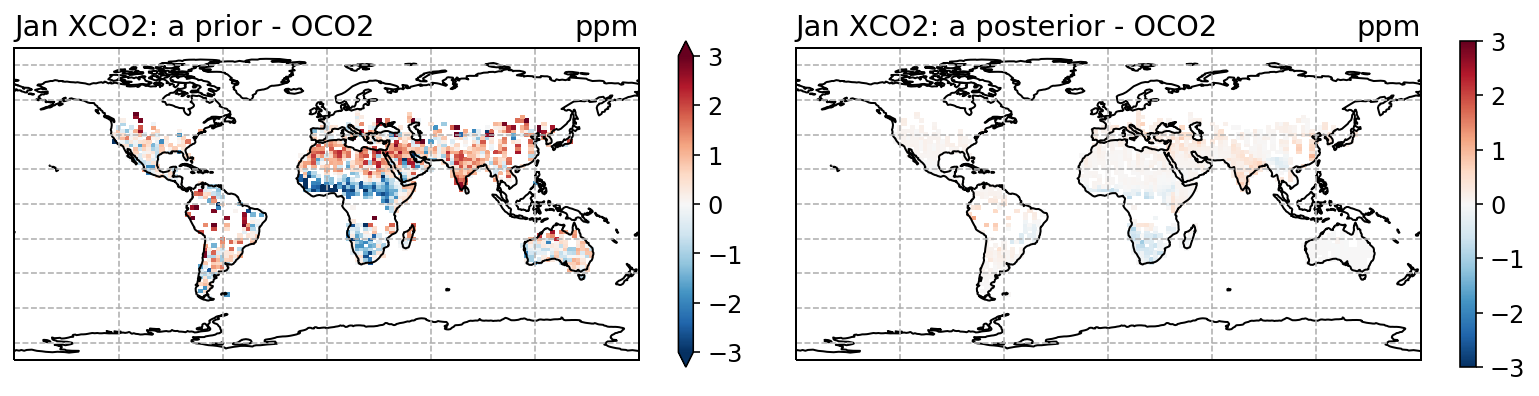

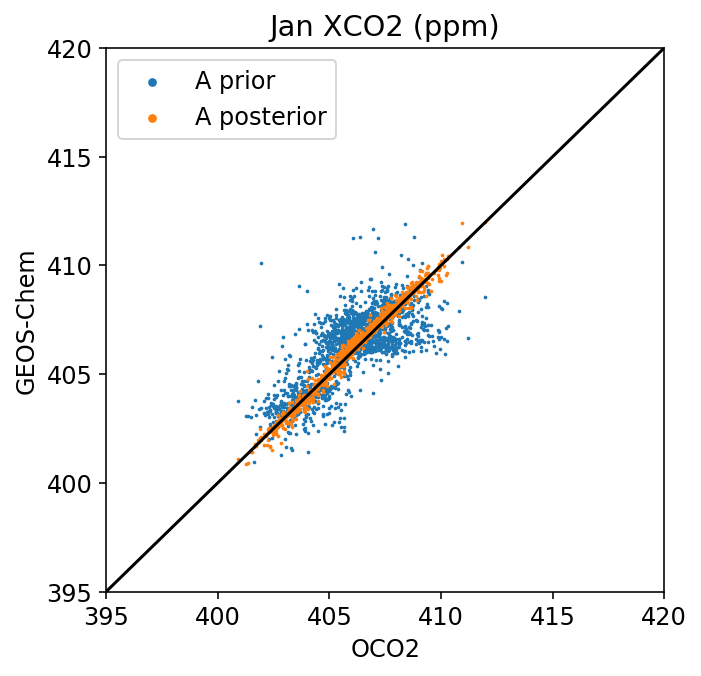

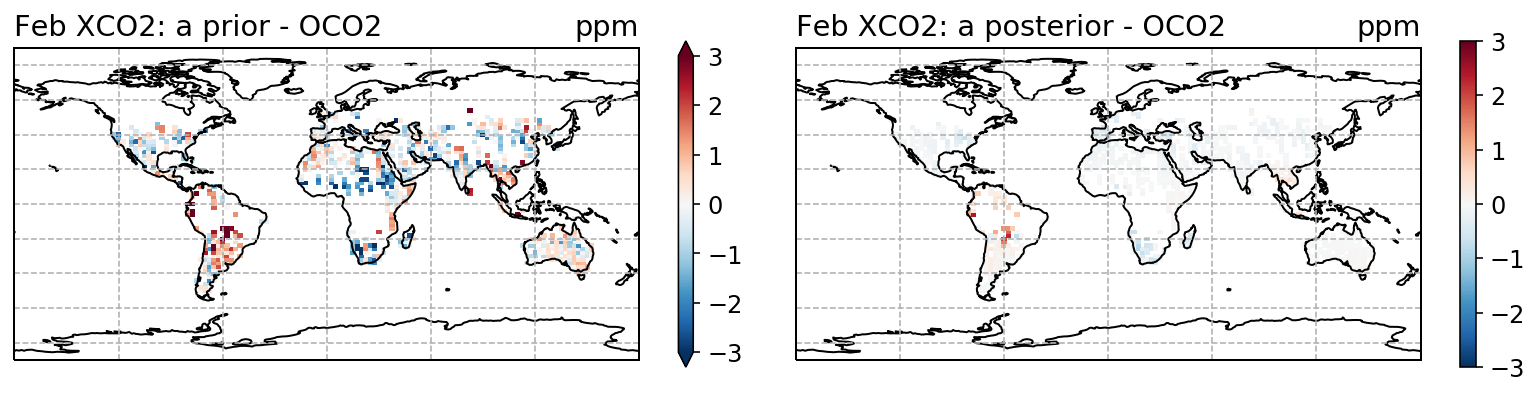

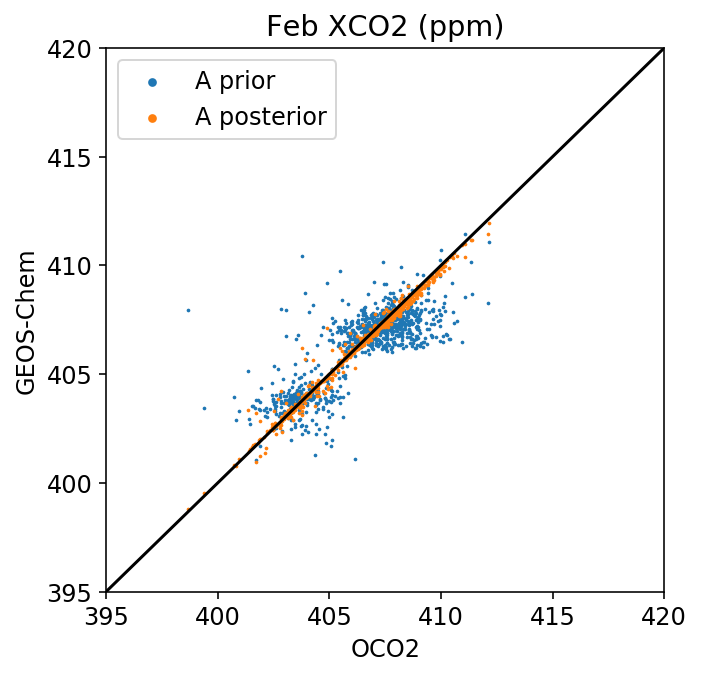

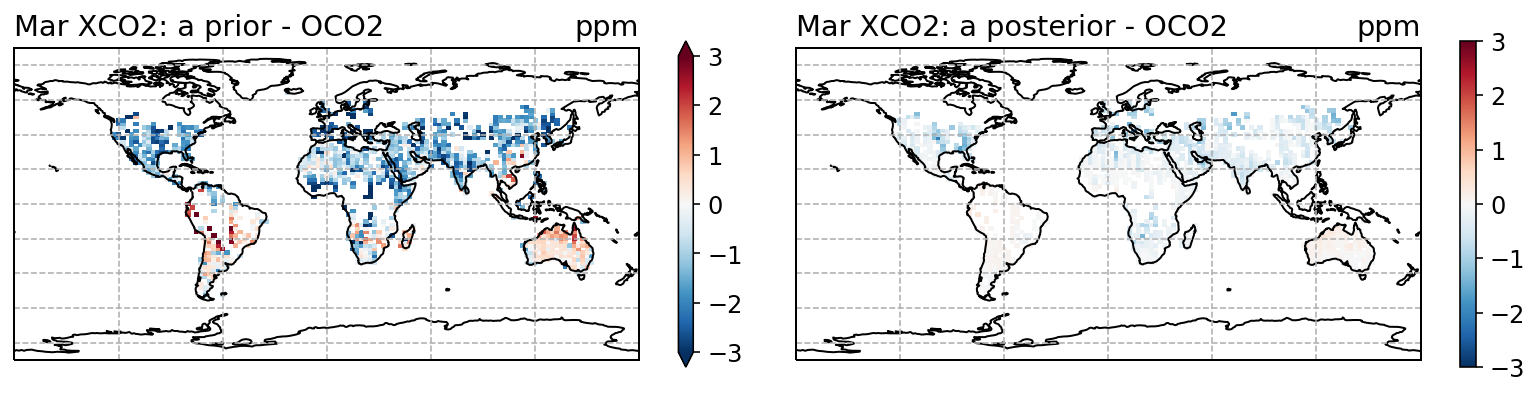

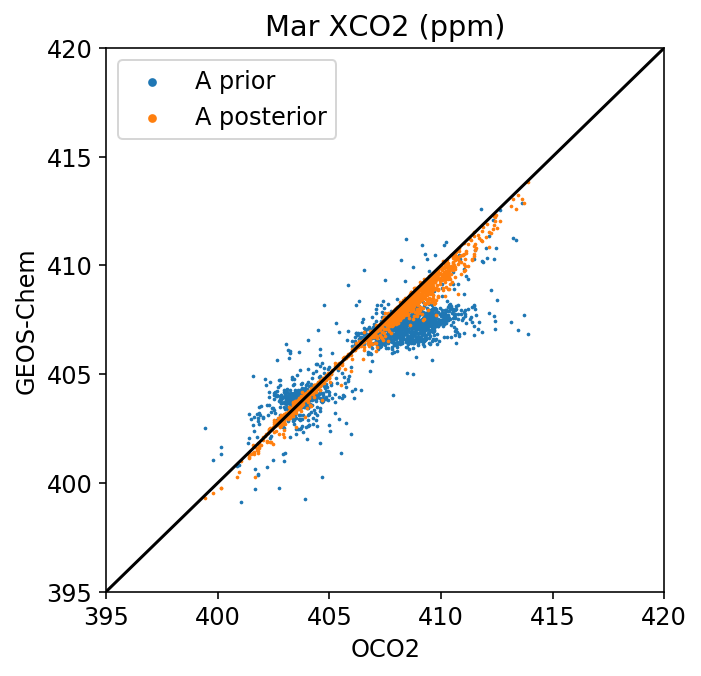

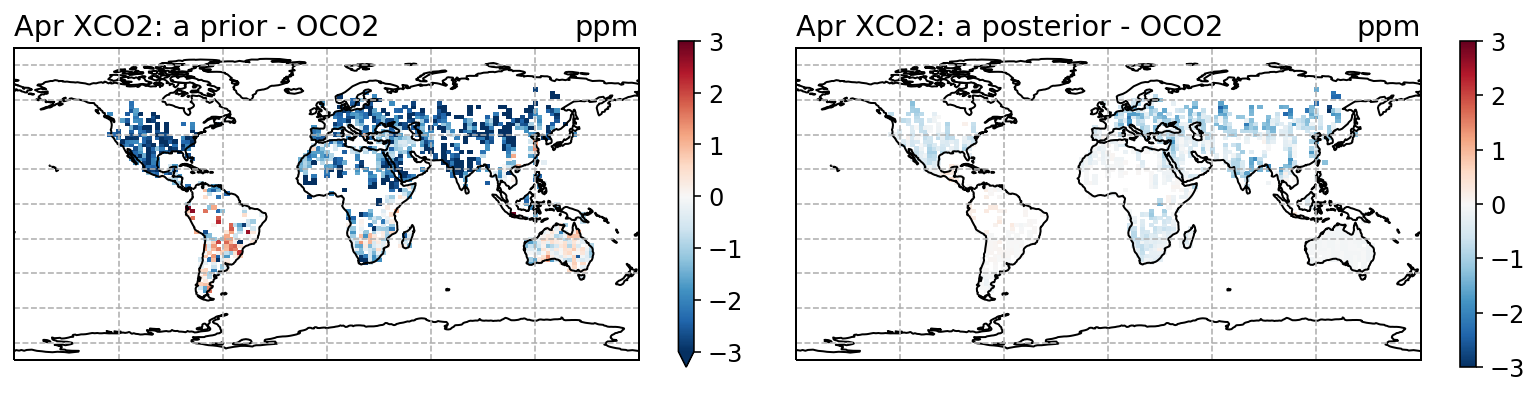

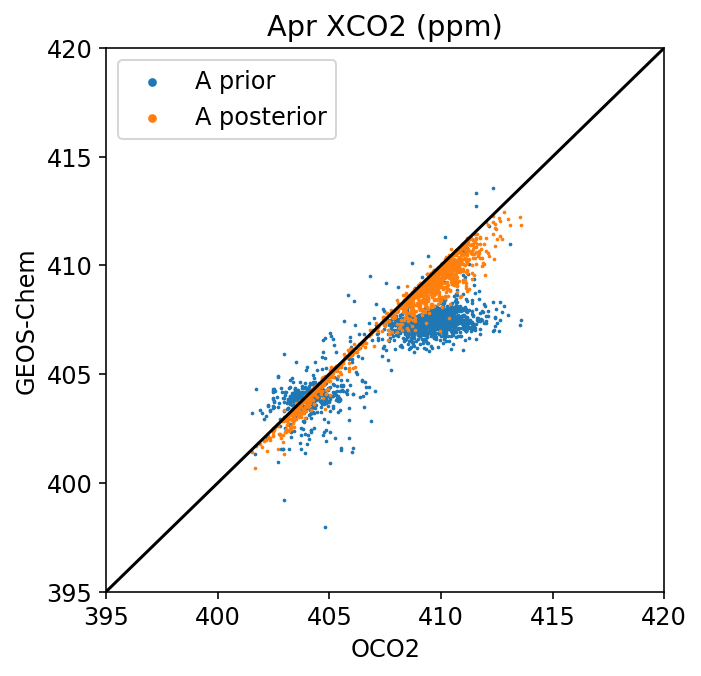

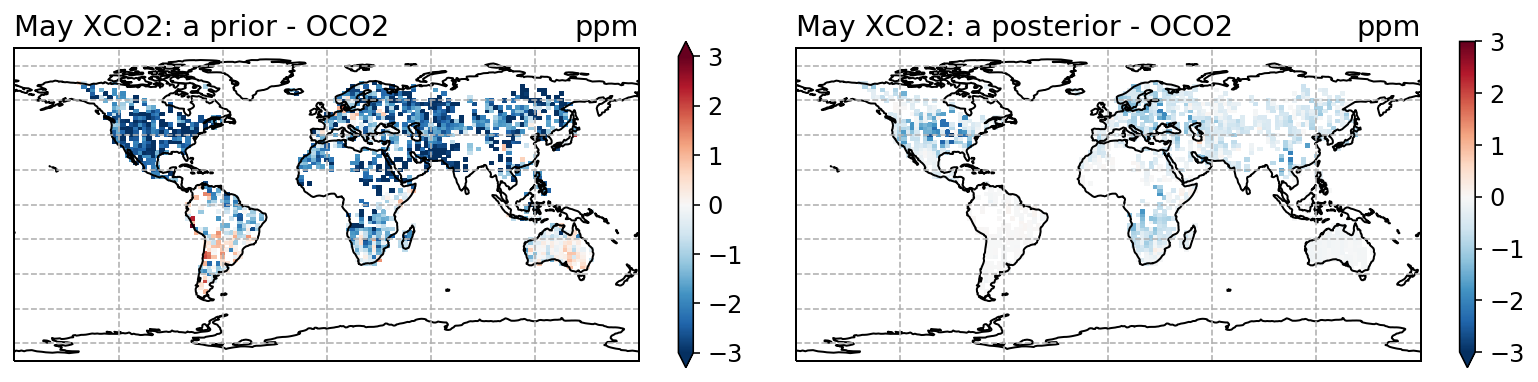

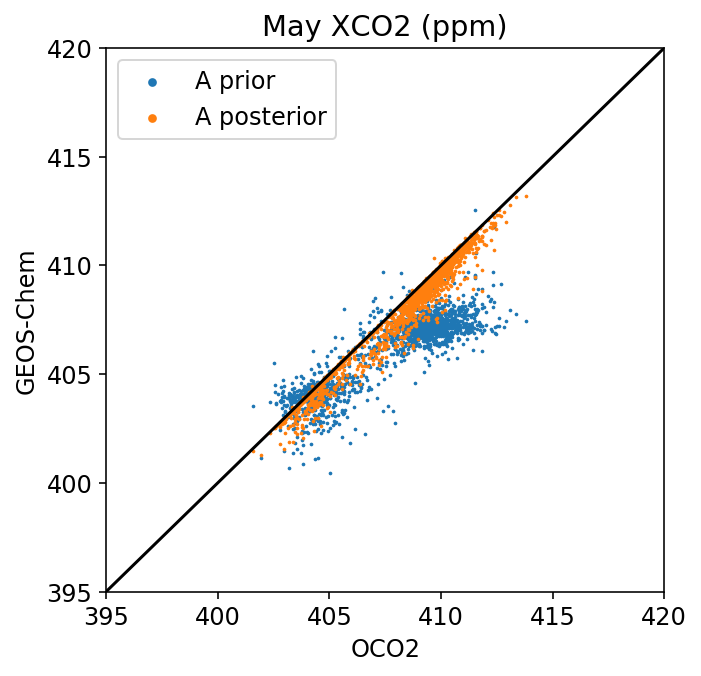

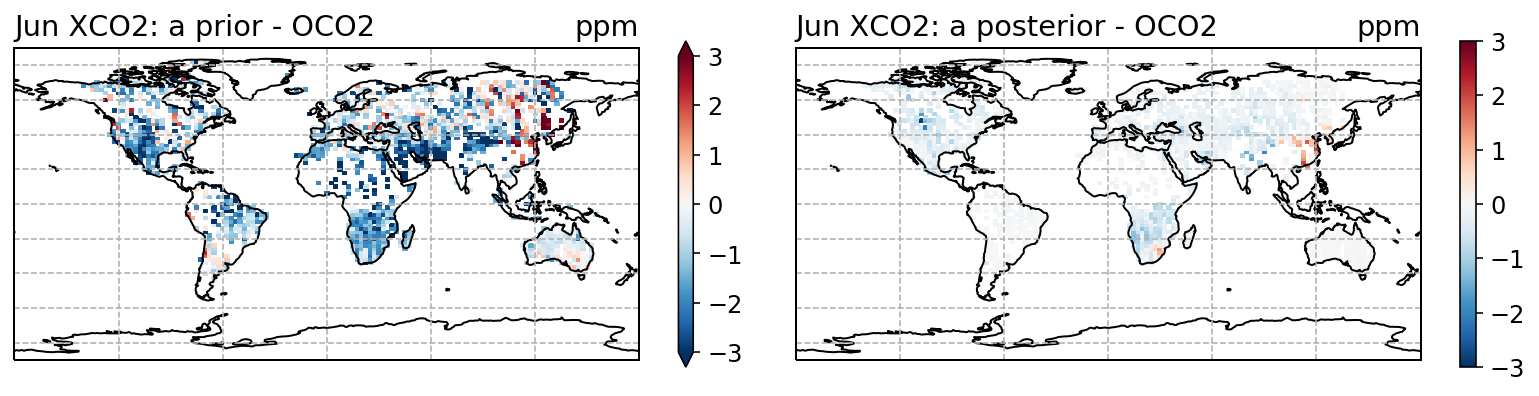

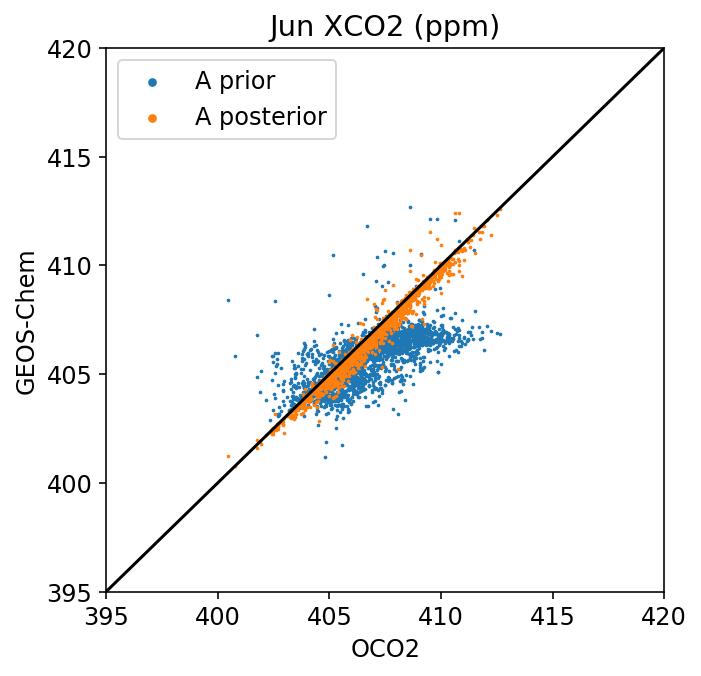

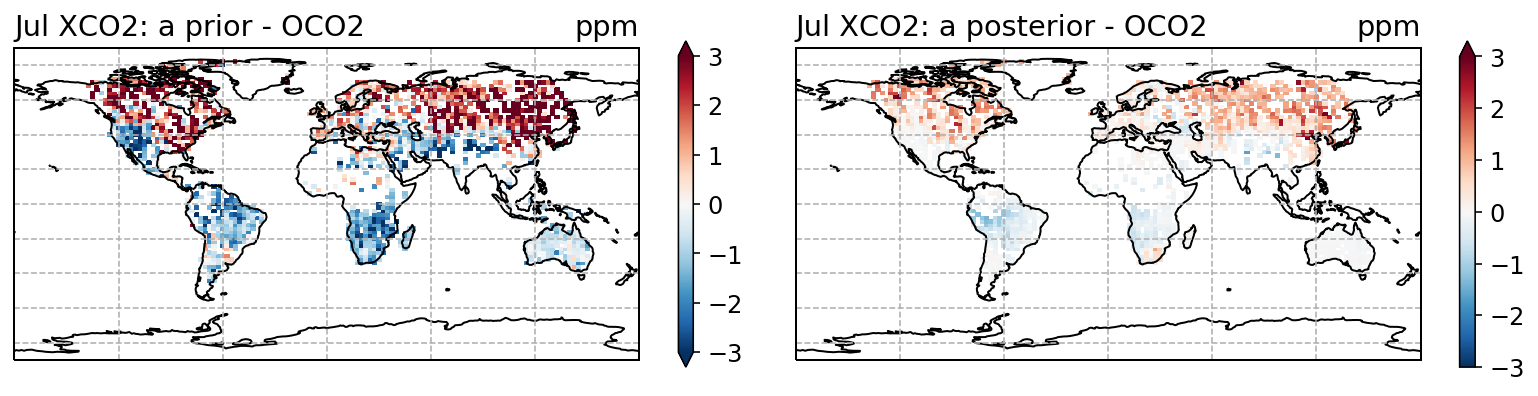

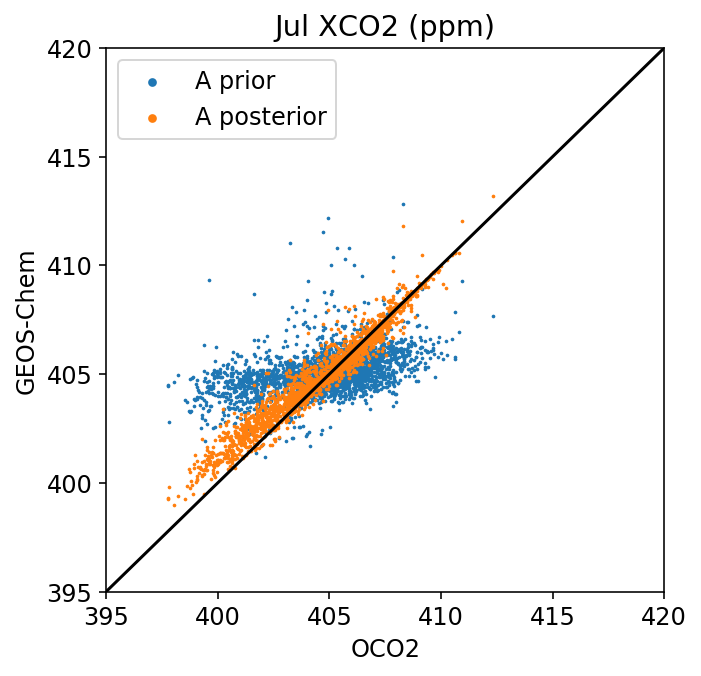

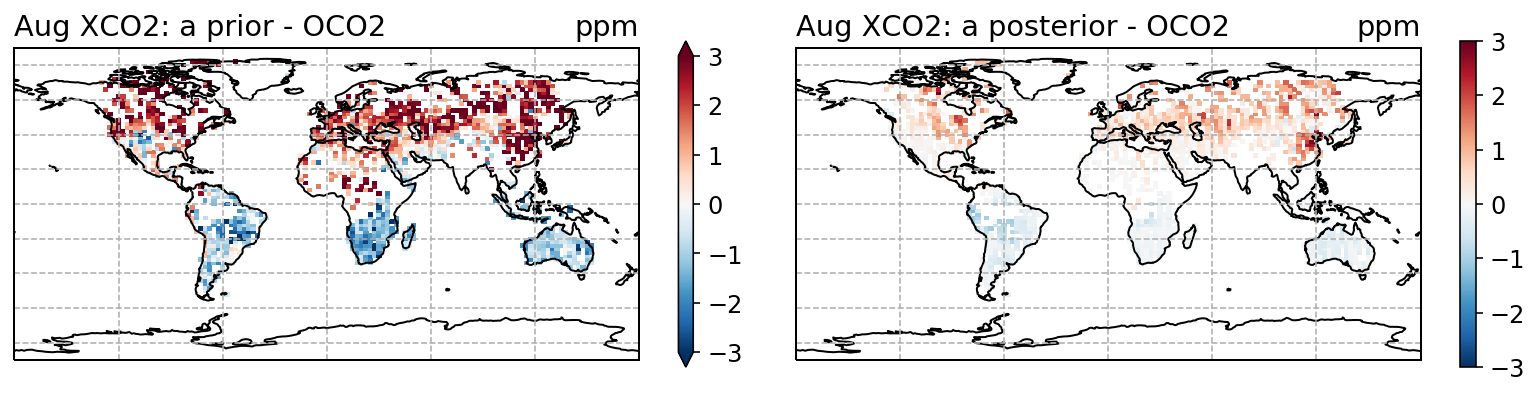

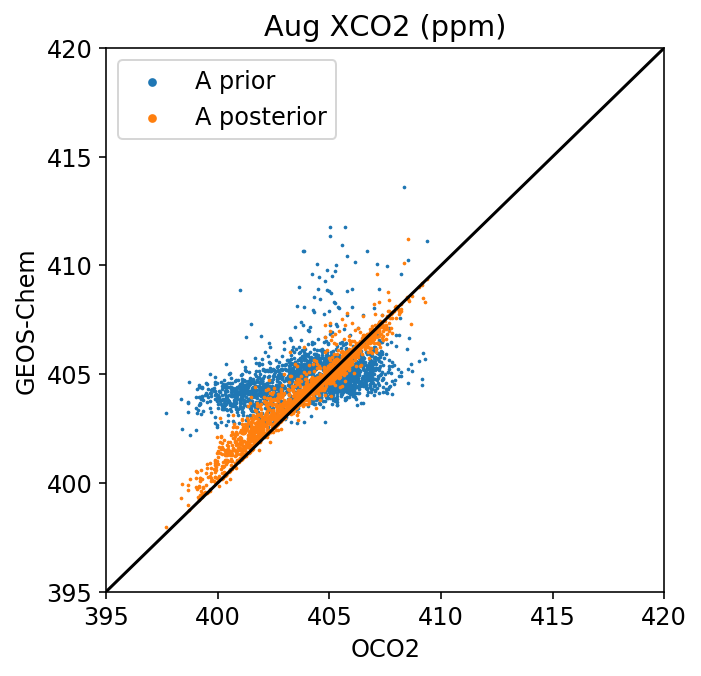

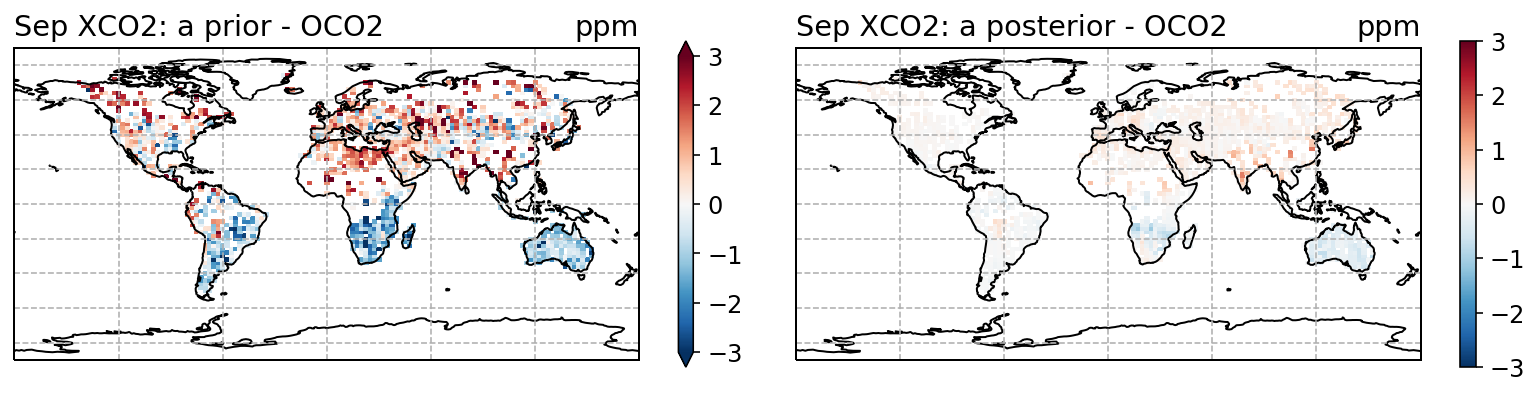

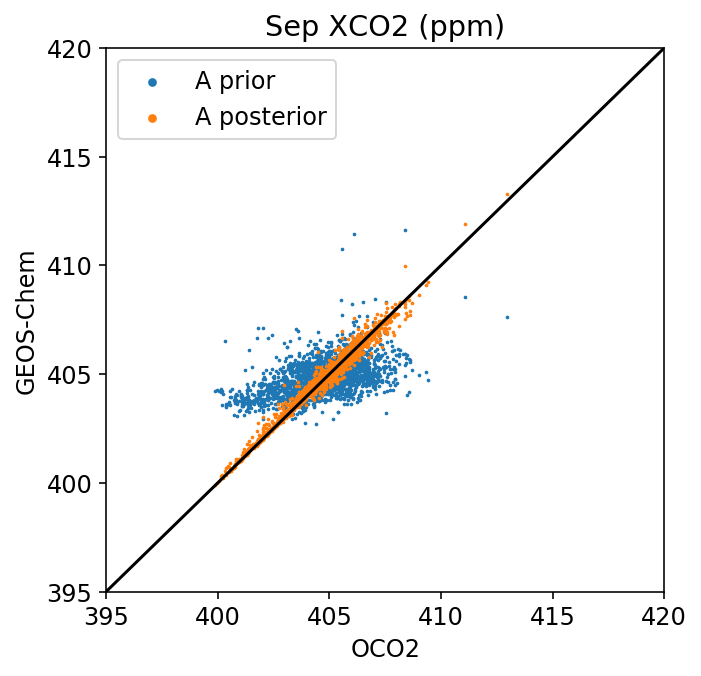

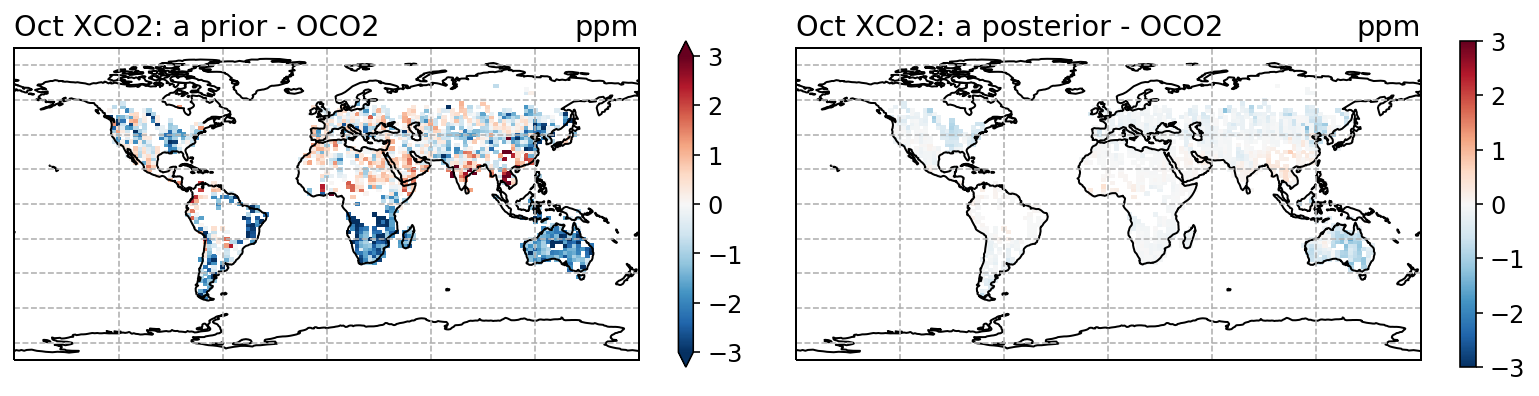

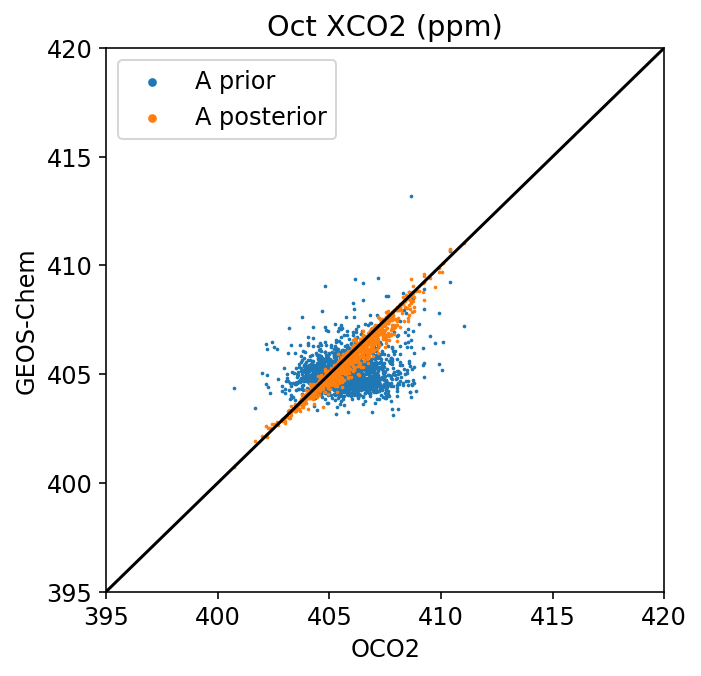

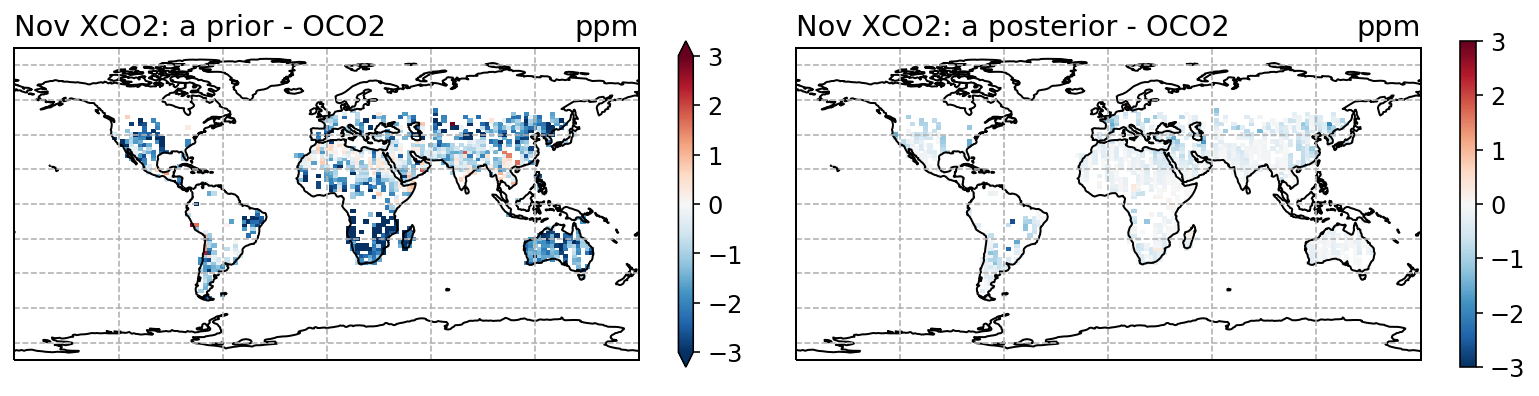

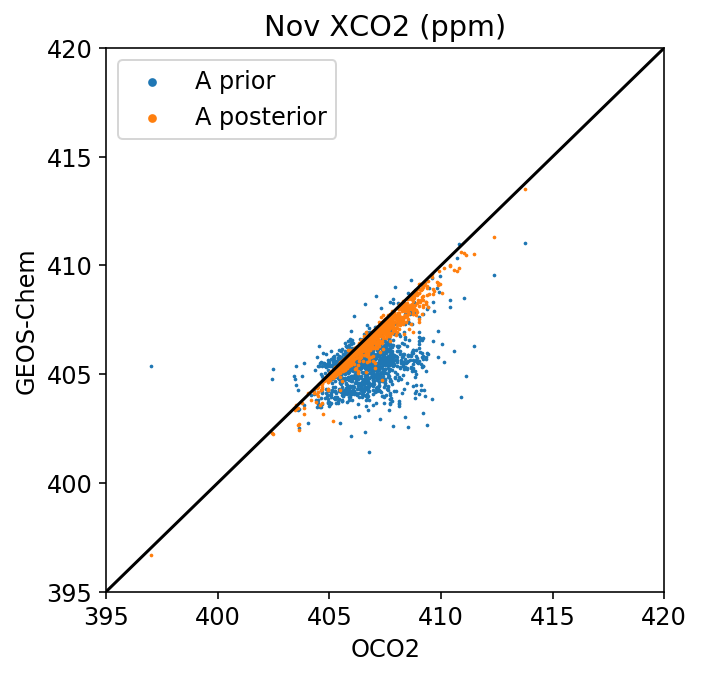

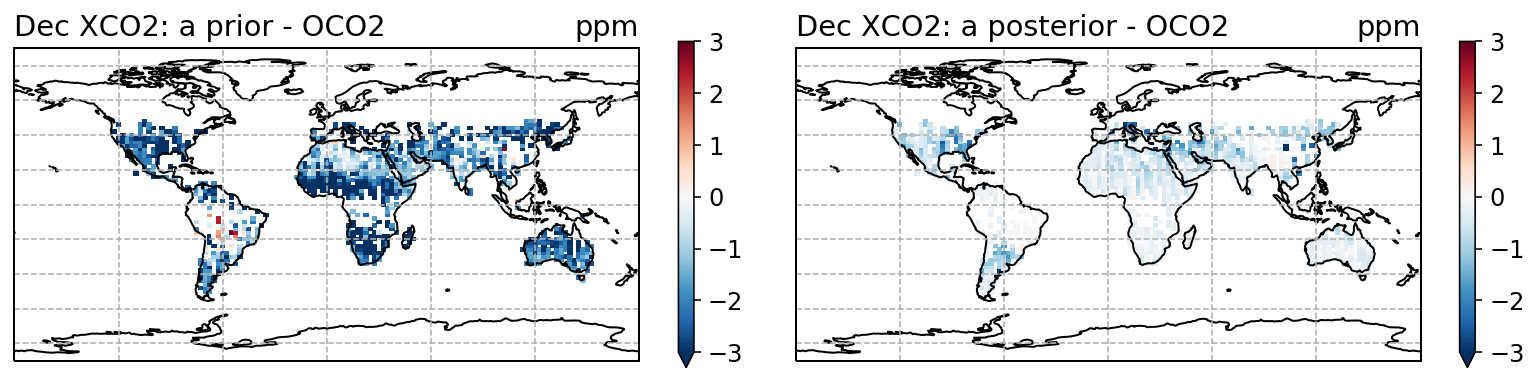

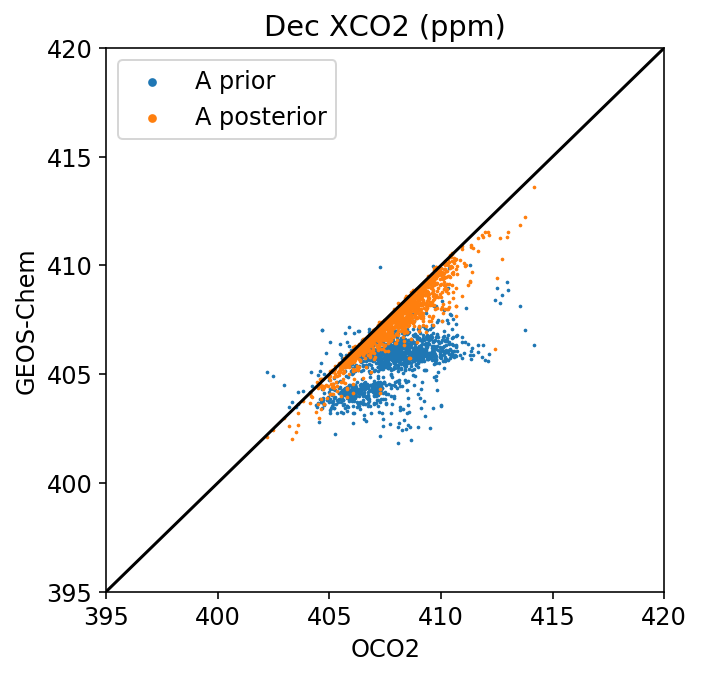

In [8]:
# sequential inversion for 12 months of output in 2018

for imonth in range(1,13):
    # read in from NetCDF files
    name_month = short_name_of_month(imonth) # Jan, Feb, Mar, ...
    ens_dir = top_dir + 'CO2-net-2018-' + month_string(imonth) + '/nd51/'
    
    if mode == 'N':
        delta_y0_file = 'delta_y0_model_N_' + str(imonth) + '.nc'
        xco2_file = 'XCO2_mod_and_oco2_N_' + name_month + '.nc'
    else:
        delta_y0_file = 'delta_y0_model_' + str(imonth) + '.nc'
        xco2_file = 'XCO2_mod_and_oco2_' + name_month + '.nc'
    # open datasets
    ds_delta_y0 = xr.open_dataset(ens_dir + delta_y0_file)
    varnames = list(ds_delta_y0.data_vars.keys())  # list of variable name
    needed_vars = [i for i in varnames if i.startswith('X_SpeciesConc_CO2Tag')] # species var names
    # separate one-year forward run with all CO2 fluxes on
    ds_xco2 = xr.open_dataset(mod_dir + xco2_file)
    xco2_oco2  = ds_xco2['xco2_oco2']  # XCO2 from OCO-2
    xco2_model = ds_xco2['xco2_model'] # XCO2 from model
    xco2_error = ds_xco2['xco2_error'] # measurement error from OCO-2
    diff = ds_xco2['xco2_oco2'] - ds_xco2['xco2_model']
    # reduce the size of above arrays and matrices, from ~400k to <3k
    x = xco2_oco2.copy()
    x = x[np.logical_not(np.isnan(x))]
    ind = x.record.values   # index for slicing
    nobs = len(ind) # number of observations used below
    # get slices of arrays
    diff_slice = diff[ind].values            # [nobs], 1-3k per month
    lat_slice = ds_xco2.lat[ind]
    lon_slice = ds_xco2.lon[ind]
    xco2_mod_slice = xco2_model[ind]
    xco2_oco_slice = xco2_oco2[ind]
    xco2_error_slice = xco2_error[ind].values

    if imonth == 1: # first month, different from others, use initial prior error
        # prior error
        del_X_f = np.diag(np.repeat(prior_err,22))
        updated_err[0,:] = np.diag(del_X_f) # store them for later
        # delta y0
        del_Y = np.empty((nobs,22))   # [nobs, nx]
        del_Y[:] = np.nan
        for itag, ivar in enumerate(needed_vars):
            del_Y[:,itag] = ds_delta_y0[ivar][ind].values
        #del_Y = np.dot(del_Y, del_X_f)
        # observation error
        obs_error = np.zeros((nobs,nobs))  # [nobs,nobs], diagonally store obs error
        for idiag in range(nobs):
            obs_error[idiag, idiag] = xco2_error_slice[idiag]**2 + mod_err**2
            # measurment error from oco2
            # model error and representation error = 2.5 for land
        # calculation of first posterior
        del_Y_tran = np.matrix.transpose(del_Y)     # del_y transpose [nx,nobs]
        first      = np.matmul(del_Y,del_Y_tran)    # del_y dot del_y_tran [nobs,nobs]
        second     = np.linalg.inv(first+obs_error) # (Y*Yt + R)^-1 [nobs,nobs]
        third      = np.matmul(del_Y_tran,second)   # Yt*(Y*Yt + R)^-1 [nx,nobs]
        k_e        = np.matmul(del_X_f,third)       # kalman gain, k_e = X_f*Yt*(Y*Yt + R)^-1 [nx,nobs]
        adjust     = np.matmul(k_e, diff_slice)     # adjustment to prior, k_e*(yobs - ym)  [nx]
        adjust_matrix[imonth-1,:] = adjust * monthly_net_flux_casa[imonth-1]
        #print('mean of yobs-ym:', "{:.2f}".format(np.mean(diff_slice)))
        print(short_name_of_month(imonth), 'adjustment: {:.2f}'.format(sum(adjust*monthly_net_flux_casa[imonth-1])))
        # update Y matrix
        diff_new = np.dot(del_Y,adjust) # [nobs], ppm
        plot_xco2_diff(diff_slice, diff_new, lat_slice, lon_slice, imonth)
        # transformation matrix to update prior
        fourth = np.identity(22) - np.matmul(third, del_Y)
        transform_mat = sp.sqrtm(fourth)
        del_X_a = np.matmul(del_X_f, transform_mat)
        # updated prior error
        updated_err[1,:] = np.diag(del_X_a)
        
    else:
        # delta y0
        del_Y = np.empty((nobs,22))
        del_Y[:] = np.nan
        for itag, ivar in enumerate(needed_vars):
            del_Y[:,itag] = ds_delta_y0[ivar][ind].values
        #del_Y = np.dot(del_Y, del_X_f)
        # observation error
        obs_error = np.zeros((nobs,nobs))
        for idiag in range(nobs):
            obs_error[idiag, idiag] = xco2_error_slice[idiag]**2 + mod_err**2
            # measurment error from oco2
            # model error and representation error = 2.5 for land
        
        # calculation of posterior
        del_Y_tran = np.matrix.transpose(del_Y)
        first      = np.matmul(del_Y,del_Y_tran)
        second     = np.linalg.inv(first+obs_error)
        third      = np.matmul(del_Y_tran,second)
        k_e        = np.matmul(del_X_f,third)    # kalman gain,
        adjust     = np.matmul(k_e, diff_slice)  # adjustment to prior
        adjust_matrix[imonth-1,:] = adjust * monthly_net_flux_casa[imonth-1]
        print(short_name_of_month(imonth), 'adjustment: {:.2f}'.format(sum(adjust*monthly_net_flux_casa[imonth-1])))
        # update Y matrix
        diff_new = np.dot(del_Y,adjust) # [nobs], ppm
        plot_xco2_diff(diff_slice, diff_new, lat_slice, lon_slice, imonth)
        # transformation matrix to use in next cycle
        fourth = np.identity(22) - np.matmul(third, del_Y)
        transform_mat = sp.sqrtm(fourth)
        del_X_a = np.matmul(del_X_f, transform_mat)
        # updated prior error
        updated_err[imonth,:] = np.diag(del_X_a)
        #del_X_f = del_X_a.copy()
        

In [9]:
adjusted = np.zeros(12) # global, monthly mean
posterior = np.zeros((12,22)) # regional, monthly mean, posterior
for i in range(22): posterior[:,i] = monthly_net_flux_casa[:,i] + adjust_matrix[:,i]
adjusted = np.sum(posterior, axis = 1)

net_flux_2018_casa = np.sum(monthly_net_flux_casa, axis = 1)
net_flux_2018_sib = np.sum(monthly_net_flux_sib, axis = 1)
Liang_monthly_global = np.sum(net_monthly_liang, axis = 1)
print('My prior net:', "{:.2f}".format(sum(net_flux_2018_casa)))
print("Liang's posterior net:", "{:.2f}".format(sum(Liang_monthly_global)))
print('My posterior net:', "{:.2f}".format(sum(adjusted)))

#pri_err_matrix = monthly_bio_flux * prior_err
#post_err_matrix = monthly_bio_flux * updated_err[:-1,:]
#np.sum(pri_err_matrix), np.sum(post_err_matrix)

My prior net: 3.89
Liang's posterior net: 4.45
My posterior net: 6.61


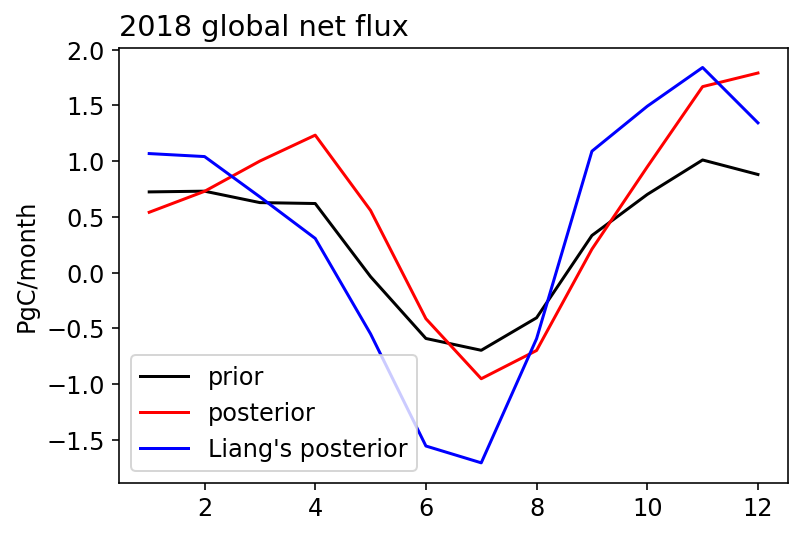

In [10]:
# plot

#pri_err_sum = np.zeros(12)
#post_err_sum = np.zeros(12)
#for i in range(12): pri_err_sum[i] = np.sqrt(sum(pri_err_matrix[i,:]**2))
#print('prior uncertainty:', "{:.2f}".format(np.sqrt(sum(pri_err_sum**2))))
#for i in range(12): post_err_sum[i] = np.sqrt(sum(post_err_matrix[i,:]**2))
#print('posterior uncertainty:', "{:.2f}".format(np.sqrt(sum(post_err_sum**2))))
    
fig, ax = plt.subplots()
# prior
ax.plot(range(1,13), net_flux_2018_casa, label = 'prior', color = 'black')
# prior
#ax.plot(range(1,13), net_flux_2018_sib, label = 'prior w/ SiB', color = 'black')
#ax.fill_between(range(1,13), net_flux_2018-pri_err_sum, net_flux_2018+pri_err_sum, color = 'black', alpha = 0.1)
# posterior
ax.plot(range(1,13), adjusted, label = 'posterior', color = 'red')
#ax.fill_between(range(1,13), adjusted-post_err_sum, adjusted+post_err_sum, color='r', alpha=.1)
# liang posterior
ax.plot(range(1,13), Liang_monthly_global, label = "Liang's posterior", color = 'blue')
plt.title('2018 global net flux', loc='left')
plt.ylabel('PgC/month')
plt.legend()

fig.savefig(mod_dir + 'bio_inversion_global.png', dpi = 300)


In [11]:
input_directory = '/geos/u73/msadiq/GEOS-Chem/analysis/inversion/data/'
df = pd.read_csv(input_directory + 'base_emission.csv')
region_names = df['name'].values

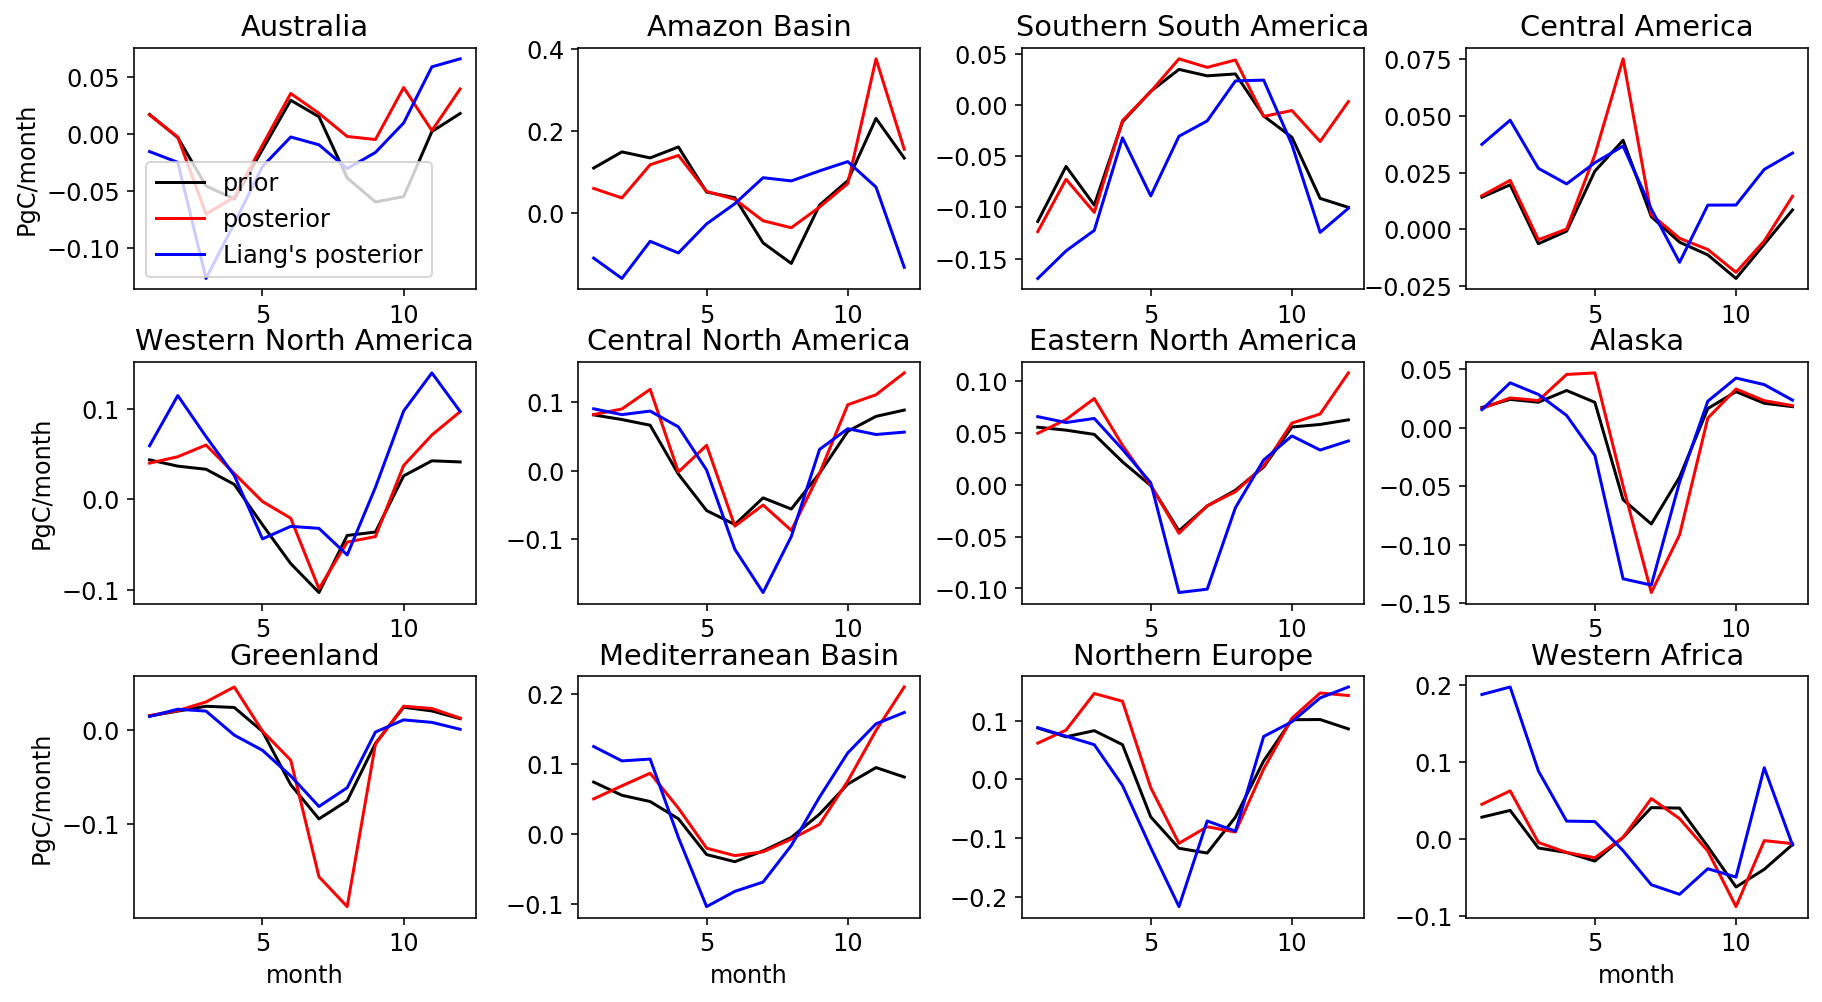

In [12]:
fig, axs = plt.subplots(3,4, figsize=(15, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace= .3)

axs = axs.ravel()

for i in range(12):
    x = range(1,13)
    #y = monthly_net_flux_sib[:,i]
    #prior_err = pri_err_matrix[:,i]
    #prior_err = abs(max(pri_err_matrix[:,i])) * 0.5
    #axs[i].plot(x, np.zeros(12), color = 'grey')
    #axs[i].plot(x, y, label = 'prior w/ SiB', color = 'black')
    #axs[i].fill_between(x, y-prior_err, y+prior_err, color = 'black', alpha = 0.1)
    
    # casa
    y = monthly_net_flux_casa[:,i]
    axs[i].plot(x, y, label = "prior", color = 'black')
    
    y = posterior[:,i]
    #updated_err = post_err_matrix[:,i]
    #updated_err = abs(max(pri_err_matrix[:,i])) * 0.3
    axs[i].plot(x, y, label = 'posterior', color = 'r')
    #axs[i].fill_between(x, y-updated_err, y+updated_err, color='r', alpha=.1)
    axs[i].set_title(region_names[i])
    
    # Liang's posterior
    y = net_monthly_liang[:,i]
    axs[i].plot(x, y, label = "Liang's posterior", color = 'blue')
    
axs[0].set_ylabel('PgC/month')
axs[4].set_ylabel('PgC/month')
axs[8].set_ylabel('PgC/month')
axs[0].legend()

axs[8].set_xlabel('month')
axs[9].set_xlabel('month')
axs[11].set_xlabel('month')

fig.savefig(mod_dir + 'bio_inversion_regions1.png', dpi = 300)


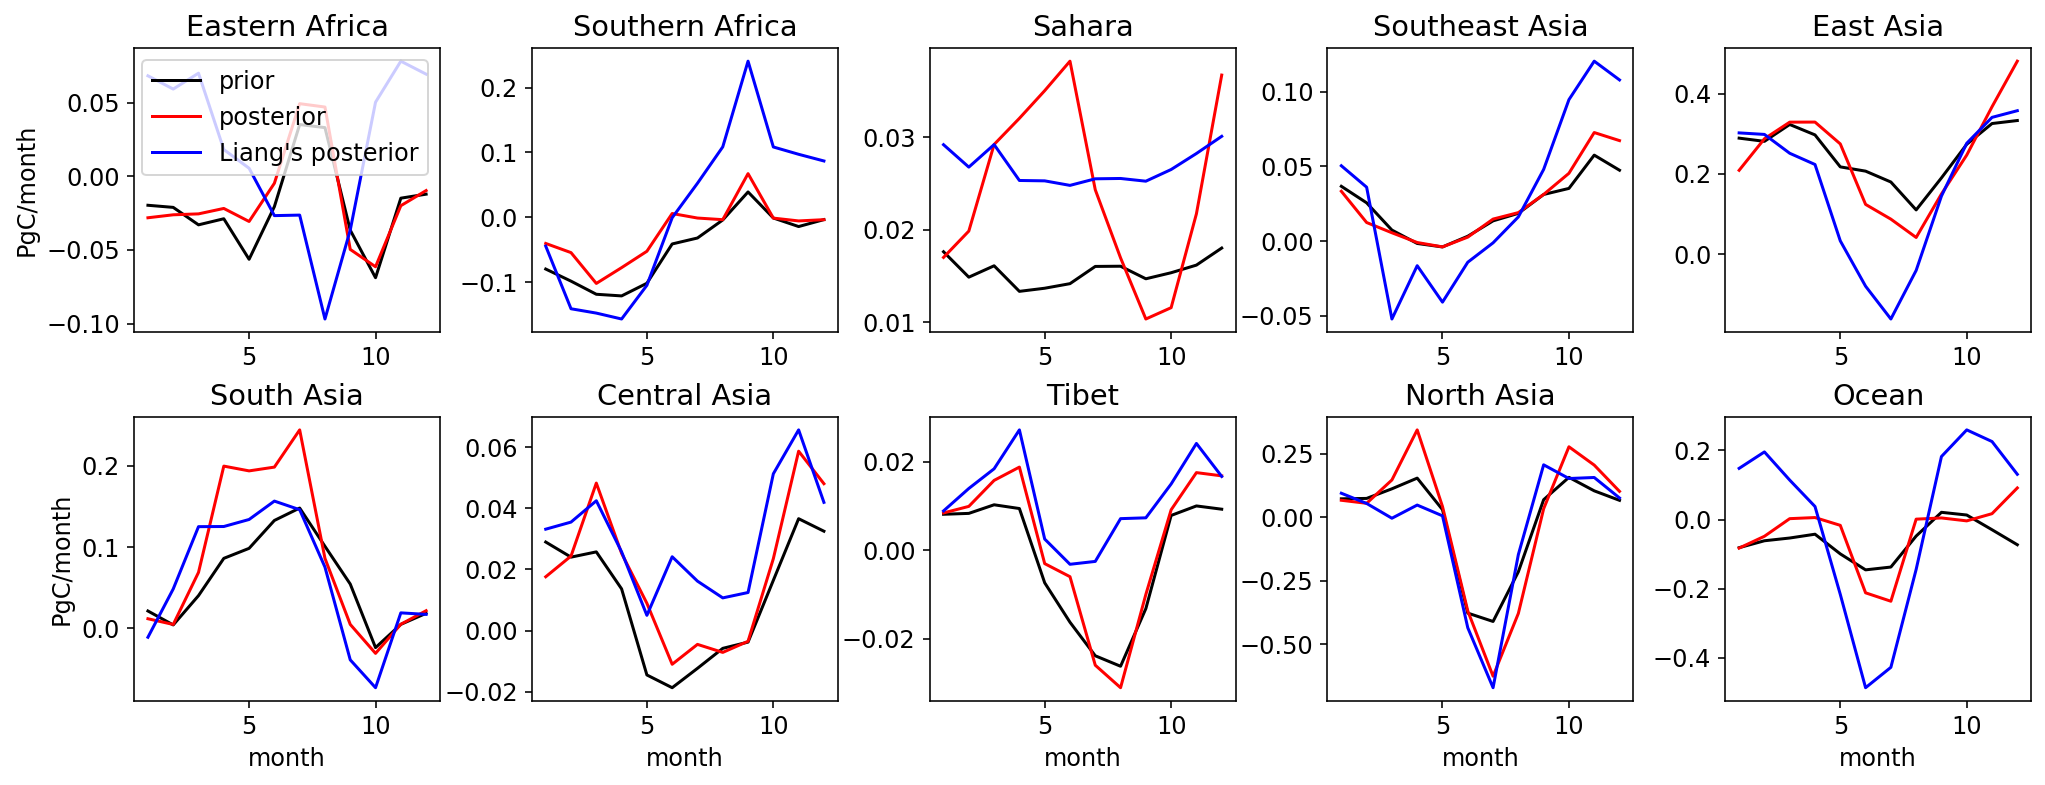

In [13]:
fig, axs = plt.subplots(2,5, figsize=(17, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3, wspace= .3)

axs = axs.ravel()

for i in range(10):
    x = range(1,13)
    imonth = i+12
    #y = monthly_net_flux_sib[:,imonth]
    #prior_err = abs(max(pri_err_matrix[:,i+12])) * 0.5
    #axs[i].plot(x, np.zeros(12), color = 'grey')
    #axs[i].plot(x, y, label = 'prior', color = 'black')
    #axs[i].fill_between(x, y-prior_err, y+prior_err, color = 'black', alpha = 0.1)
    
    # casa
    y = monthly_net_flux_casa[:,imonth]
    axs[i].plot(x, y, label = "prior", color = 'black')
    
    y = posterior[:,imonth]
    #updated_err = post_err_matrix[:,i+12]
    #updated_err = abs(max(pri_err_matrix[:,i+12])) * 0.3
    axs[i].plot(x, y, label = 'posterior', color = 'r')
    #axs[i].fill_between(x, y-updated_err, y+updated_err, color='r', alpha=.1)
    axs[i].set_title(region_names[imonth])
    
    # Liang's posterior
    y = net_monthly_liang[:,imonth]
    axs[i].plot(x, y, label = "Liang's posterior", color = 'blue')
    
axs[0].set_ylabel('PgC/month')
axs[5].set_ylabel('PgC/month')
axs[0].legend()

axs[5].set_xlabel('month')
axs[6].set_xlabel('month')
axs[7].set_xlabel('month')
axs[8].set_xlabel('month')
axs[9].set_xlabel('month')

fig.savefig(mod_dir + 'bio_inversion_regions2.png', dpi = 300)


In [14]:
ds_xco2 = xr.open_dataset(mod_dir + xco2_file)
xco2_oco2  = ds_xco2['xco2_oco2']  # XCO2 from OCO-2
xco2_model = ds_xco2['xco2_model'] # XCO2 from model
xco2_error = ds_xco2['xco2_error'] # measurement error from OCO-2
diff = ds_xco2['xco2_oco2'] - ds_xco2['xco2_model']
# reduce the size of above arrays and matrices, from ~400k to <3k
x = xco2_oco2.copy()
x = x[np.logical_not(np.isnan(x))]
ind = x.record.values   # index for slicing
nobs = len(ind) # number of observations used below
print('nobs:', nobs)
# get slices of arrays
diff_slice = diff[ind].values            # [nobs], 1-3k per month
lat_slice = ds_xco2.lat[ind]
lon_slice = ds_xco2.lon[ind]
xco2_mod_slice = xco2_model[ind]
xco2_oco_slice = xco2_oco2[ind]
diff_new = diff_new

#plot_xco2_diff(diff_slice, diff_new, lat_slice, lon_slice, 12)
np.mean(diff_slice), np.mean(diff_new)


nobs: 1467


(2.2050772, 0.48246853945307006)